# Anticipez les besoins en consommation de bâtiments.

## Notebook de prédiction des consommations d'energies.

J'importe les librairies nécessaires.

In [2]:
import pandas as pd
import numpy as np
import shap
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

In [3]:
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0,Age,NumberofFloors,NumberofBuildings,PropertyGFABuilding(s),PropertyGFATotal,LargestPropertyUseTypeGFA,ProportionBuildingSurface,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,PrimaryPropertyType,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore
0,0,95,12,1.0,88434,88434,88434.0,100.000000,No,No,Hotel,7.965669,22.830146,60.0
1,1,26,11,1.0,88502,103566,83880.0,85.454686,Yes,Yes,Hotel,8.208771,23.046682,61.0
2,2,53,41,1.0,759392,956110,756493.0,79.425171,No,No,Hotel,11.028790,26.139795,43.0
3,3,96,10,1.0,61320,61320,61320.0,100.000000,No,No,Hotel,8.162039,22.727917,56.0
4,4,42,18,1.0,113580,175580,123445.0,64.688461,Yes,Yes,Hotel,8.980168,23.805038,75.0


Je redéfinis mon DataFrame qui sera utilisé dans ce notebook.

In [4]:
data_energy = data.loc[:, ["Age", "NumberofFloors", "NumberofBuildings", "PropertyGFABuilding(s)", "PropertyGFATotal", "LargestPropertyUseTypeGFA", "ProportionBuildingSurface", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "PrimaryPropertyType", "SiteEnergyUseWN(kBtu)"]]
data = data.drop(columns = "Unnamed: 0")

Je vais créer la matrice de données (composée des variables intéressantes) et le vecteur d'étiquette (composé de la variable concernant les consommations d'énergies).

In [5]:
X = data_energy[data_energy.columns[:-1]].values
y = data_energy["SiteEnergyUseWN(kBtu)"].values

Je crée un jeu d'entraînement et un jeu de test (30% des données).

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)

### 1) Choix du modèle.

Je crée un transformer pour encoder mes variables catégorielles.

In [7]:
transformer = ColumnTransformer(transformers = [("ohe", OneHotEncoder(handle_unknown = "ignore", sparse = False), [7, 8, 9])],
                                remainder = "passthrough")

Je crée un pipeline pour agréger les étapes de processing pour tester les modèles de base.

In [8]:
steps = [("t", transformer), ("std", StandardScaler(with_mean=False)), ("model", SVR())]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
print(X_train)

[[14 2 1.0 ... 'No' 'No' 'K-12 School']
 [22 11 1.0 ... 'Yes' 'No' 'Small- and Mid-Sized Office']
 [97 18 1.0 ... 'Yes' 'Yes' 'Medical Office']
 ...
 [121 2 1.0 ... 'No' 'No' 'Worship Facility']
 [62 1 1.0 ... 'Yes' 'No' 'Warehouse']
 [9 1 1.0 ... 'No' 'No' 'Other']]


J'utilise GridSearchCV pour trouver le modèle qui correspond le mieux à mon problème ainsi que son score. Nous sommes face à un problème de régression et non de classification, je teste donc que des modèles de régression.

In [9]:
param_grid = {"model" : [LinearRegression(),
                         KNeighborsRegressor(),
                         SVR(),
                         DecisionTreeRegressor(),
                         RandomForestRegressor(),
                         GradientBoostingRegressor(),
                         xgb.XGBRegressor()]
             }


In [10]:
grid = GridSearchCV(pipe, param_grid, cv = 5, return_train_score=True)
grid.fit(X_test, y_test)
print ("Best: ", grid.best_score_, "using ", grid.best_params_)

Best:  0.6963522249539942 using  {'model': GradientBoostingRegressor()}


Le modèle qui correspond le mieux est celui de la régression XGBoost.

J'analyse ensuite les performances des autres modèles à titre comparatif.

In [11]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.034719,0.013393,0.005804,0.002741,LinearRegression(),{'model': LinearRegression()},-5.721075e+25,0.577085,0.612581,0.580238,...,-1.144215e+25,2.288430e+25,7,0.666746,0.651858,0.646464,0.650281,0.646780,0.652426,0.007449
1,0.013500,0.008077,0.015560,0.005866,KNeighborsRegressor(),{'model': KNeighborsRegressor()},4.800120e-01,0.493071,0.544059,0.571041,...,5.214855e-01,3.315970e-02,5,0.711775,0.705098,0.684259,0.687425,0.688528,0.695417,0.010928
2,0.021087,0.006405,0.006302,0.001797,SVR(),{'model': SVR()},5.624930e-01,0.646955,0.627468,0.663290,...,6.370121e-01,4.176701e-02,3,0.697160,0.670865,0.685660,0.680170,0.676425,0.682056,0.008963
3,0.005478,0.000759,0.001386,0.000162,DecisionTreeRegressor(),{'model': DecisionTreeRegressor()},4.629421e-01,0.444558,0.434172,0.579261,...,4.439524e-01,8.924775e-02,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.373226,0.102209,0.016295,0.007489,RandomForestRegressor(),{'model': RandomForestRegressor()},6.609589e-01,0.670828,0.610530,0.689950,...,6.684400e-01,3.346541e-02,2,0.952420,0.953324,0.952907,0.951836,0.952148,0.952527,0.000532
5,0.067353,0.002223,0.001791,0.000451,GradientBoostingRegressor(),{'model': GradientBoostingRegressor()},6.931100e-01,0.678705,0.670879,0.719155,...,6.963522e-01,2.022782e-02,1,0.884183,0.880070,0.875189,0.872440,0.880162,0.878409,0.004127
6,0.098090,0.004018,0.006039,0.002707,"XGBRegressor(base_score=None, booster=None, ca...","{'model': XGBRegressor(base_score=None, booste...",6.280114e-01,0.614996,0.543007,0.669565,...,6.217607e-01,4.373141e-02,4,0.999296,0.998959,0.999480,0.998978,0.999029,0.999149,0.000205


### 2) Optimisation du modèle.

Je vais donc appliquer ce modèle à mon jeu de données et chercher les meilleurs hyperparamètres.

In [12]:
steps = [("t", transformer), ("gbr", GradientBoostingRegressor())]
pipe = Pipeline(steps)
print(steps[1][1])

GradientBoostingRegressor()


J'utilise un RandomizedSearchCV pour avoir une idée des valeurs qui peuvent être prises par les hyperparamètres.

In [13]:
parameters = {'gbr__learning_rate': sp_randFloat(),
                  'gbr__subsample'    : sp_randFloat(),
                  'gbr__n_estimators' : sp_randInt(100, 500),
                  'gbr__max_depth'    : sp_randInt(4, 10)
                 }

In [14]:
random = RandomizedSearchCV(estimator=pipe, param_distributions = parameters, cv = 2, n_iter = 10, n_jobs=-1)
random.fit(X_train, y_train)
print ("Best: ", random.best_score_, "using ", random.best_params_)

Best:  0.6480960810100328 using  {'gbr__learning_rate': 0.4380916923653304, 'gbr__max_depth': 4, 'gbr__n_estimators': 113, 'gbr__subsample': 0.8183347590060245}


Je cherche les meilleurs hyperparamètres pour mon modèle.

In [15]:
param_grid = {"gbr__n_estimators" : [100, 500],
              "gbr__learning_rate" : [0.01, 0.1, 1.0],
              "gbr__subsample" : [0.5, 1.0],
              "gbr__max_depth" : [3, 5, 7, 9]
                }

In [16]:
grid = GridSearchCV(pipe, param_grid, n_jobs = -1, cv = 5)
grid.fit(X_train, y_train)
print ("Best: ", grid.best_score_, "using ", grid.best_params_)

Best:  0.7189992452502691 using  {'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__n_estimators': 100, 'gbr__subsample': 0.5}


J'analyse la performance sur le jeu de test.

In [17]:
pipe.set_params(**grid.best_params_)
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print("Performance on the test set: ", score)

Performance on the test set:  0.7301458206692613


### 3) Energy Star Score.

Je vais inclure l'EnergyStarScore dans mon DataFrame afin de voir si il a un impact sur la modélisation.

In [18]:
data_ess = data.loc[:, ["Age", "NumberofFloors", "NumberofBuildings", "PropertyGFABuilding(s)", "PropertyGFATotal", "LargestPropertyUseTypeGFA", "ProportionBuildingSurface", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "PrimaryPropertyType", "ENERGYSTARScore", "SiteEnergyUseWN(kBtu)"]]

In [19]:
X = data_ess[data_ess.columns[:-1]].values
y = data_ess["SiteEnergyUseWN(kBtu)"].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)

J'utilise le même modèle avec les mêmes paramètres.

In [20]:
pipe.set_params(**grid.best_params_)
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print("Performance on testing set: ", score)

Performance on testing set:  0.7920666733511316


### 4) Feature importance.

J'analyse l'importance des features.

In [21]:
coefficients = pipe.steps[1][1].feature_importances_ 

In [22]:
cat = ["Age", "NumberofFloors", "NumberofBuildings", "PropertyGFABuilding(s)", "PropertyGFATotal", "LargestPropertyUseTypeGFA", "ProportionBuildingSurface", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "PrimaryPropertyType", "ENERGYSTARScore"]

In [23]:
features = pipe["t"].get_feature_names_out(cat)

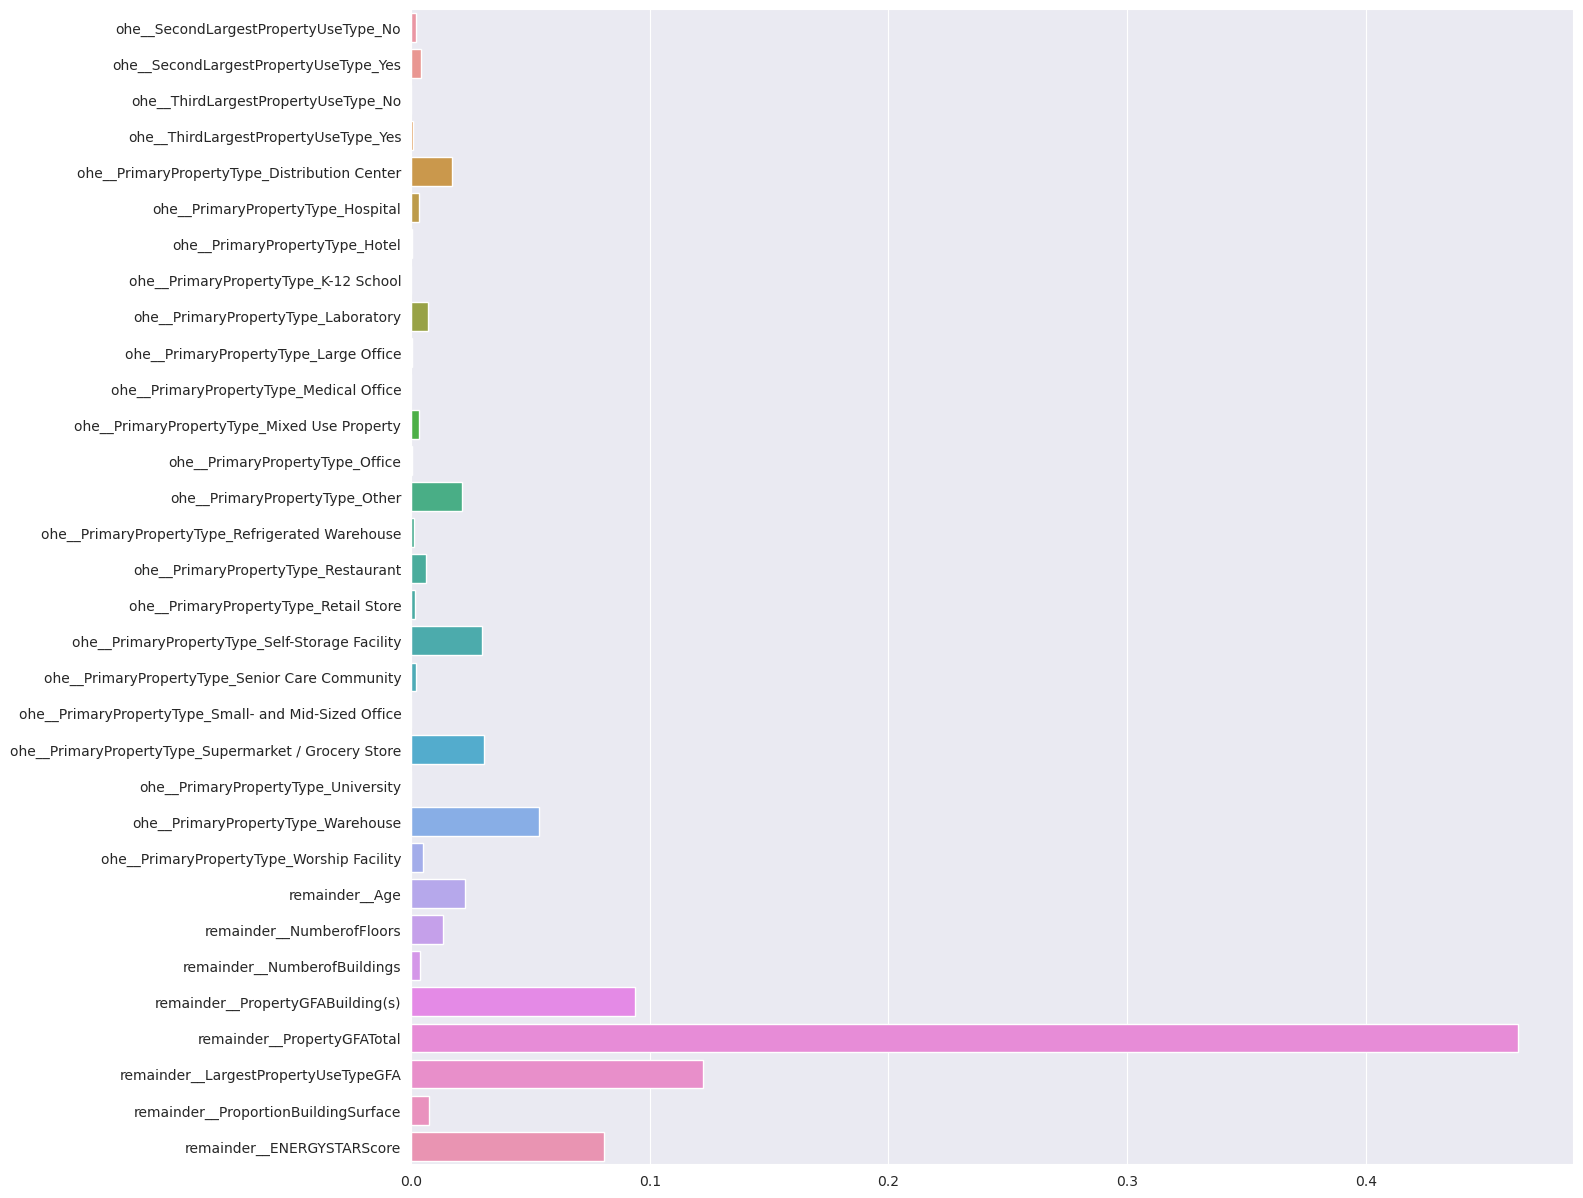

In [24]:
plt.figure(figsize=(15, 15))
sns.barplot( y = features, x = coefficients)
plt.show()

J'analyse l'importance des features à l'aide de shap.

In [25]:
model = pipe.steps[1][1]
model

GradientBoostingRegressor(subsample=0.5)

In [26]:
features = pipe["t"].transform(X)

In [27]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

In [28]:
feature_names = pipe["t"].get_feature_names_out(cat)

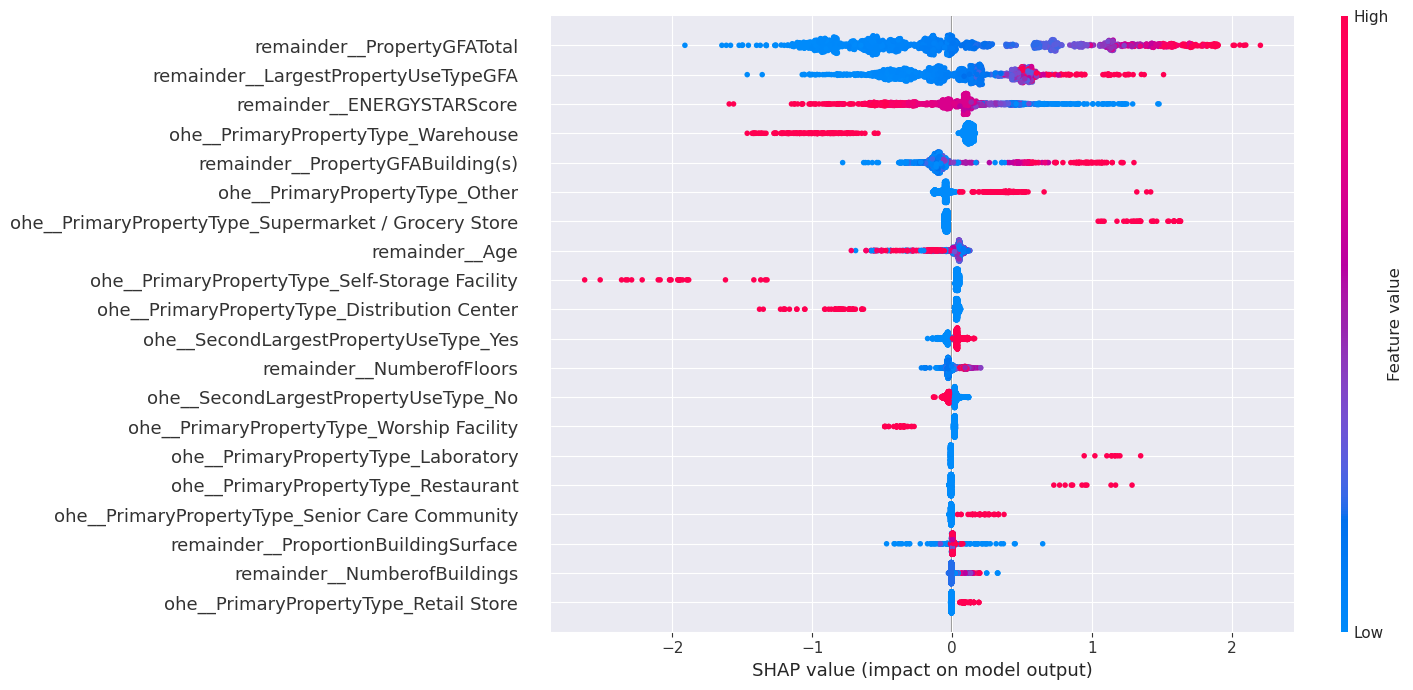

In [29]:
shap.summary_plot(shap_values, features, feature_names, plot_size = (15, 7))